# Winequality dataset

## Feim els imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression, RFE
from feature_engine.creation import MathematicalCombination, CombineWithReferenceFeature

## Preparam el dataset

Funció que separa les features i les etiquetes, escalant les dades

In [2]:
def load_data(df):
    y=df.quality
    X=df.drop('quality',axis=1)
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [3]:
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['type']="Red"
dfWhite['type']="White"
df = pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents i les eliminam

In [4]:
df[df.isna().any(axis=1)]
df.dropna(inplace=True)

Convertim els valors categòrics en númerics

In [5]:
labelencoder = preprocessing.LabelEncoder()

df['type']=labelencoder.fit_transform(df['type'])

Recolocam les columnes

In [6]:
df = df.reindex(columns=['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol', 'type', 'quality'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type                  6497 non-null   int32  
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 685.2 KB


In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5


Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes). \
\
A continuació podem observar les correlacions entre els distints atributs.

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1)

features, labels = load_data(df)

### Separació del conjunt d'entrenament i el de test
Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Visualització de les dades

<AxesSubplot:>

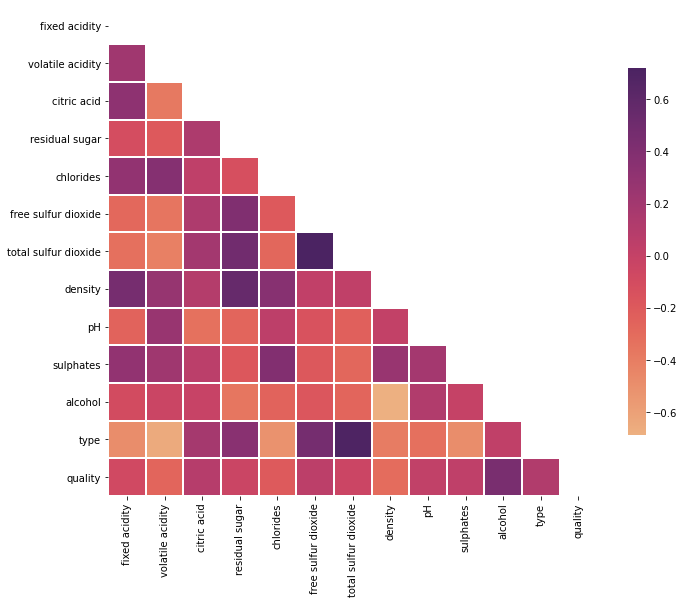

In [11]:
np.set_printoptions(linewidth=300)

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

corr = df.corr()

# Generam una màscara pel triangle superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Preparam el gràfic de pyplot
f, ax = plt.subplots(figsize=(11, 9))

# Dibuixam el mapa de calor amb la màscara i alguns paràmetres extra per millorar el resultat visual
sns.heatmap(corr, mask=mask, cmap="flare", square=True, linewidths=.25, cbar_kws={"shrink": .75})


Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

array([[<AxesSubplot:title={'center':'fixed acidity'}>, <AxesSubplot:title={'center':'volatile acidity'}>, <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>, <AxesSubplot:title={'center':'chlorides'}>, <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>, <AxesSubplot:title={'center':'density'}>, <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>, <AxesSubplot:title={'center':'alcohol'}>, <AxesSubplot:title={'center':'quality'}>]], dtype=object)

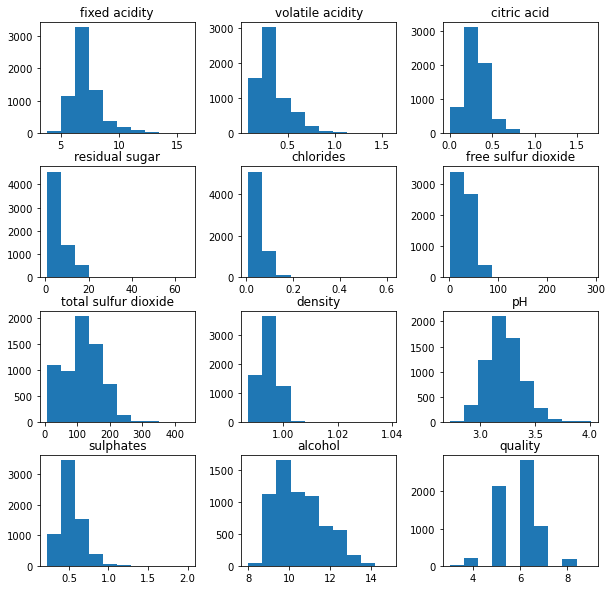

In [12]:
df.drop("type", axis=1).hist(figsize=(10,10), grid=False)

<AxesSubplot:>

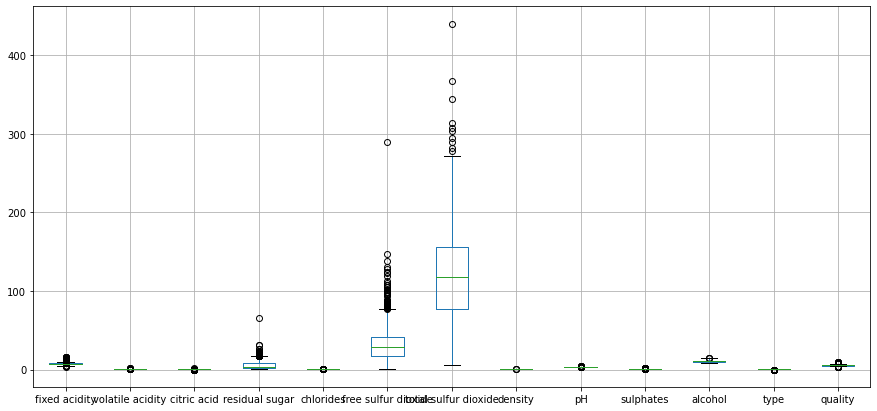

In [46]:
df.boxplot(figsize=(15,7))

Gràfic cirular en el que podem veure la proporció de vi blanc i vermell del dataframe

1    4898
0    1599
Name: type, dtype: int64
1    75.388641
0    24.611359
Name: type, dtype: float64


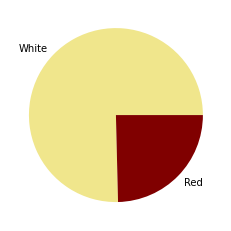

In [45]:
plt.pie(df['type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['type'].value_counts())
print(df['type'].value_counts(normalize=True)*100)

Aqui podem veure la quantitat de mostres de cada tipus

In [48]:
df['type'].hist()

AttributeError: 'tuple' object has no attribute 'get_figure'

<Figure size 432x288 with 0 Axes>

# **Classificadors**

Per a cada model imprimim el seu classification report, la precisió de training i la de testing. A més, guardam aquests dos valors dins dos dataframes externs per després poder comparar les modificacions que farem al dataframe original.

Hem decidit fer els models dins funcions per poder cridar-les des de l'apartat d'[Enginyeria de característiques/Proves](#Proves) fora haver de reescriure el codi.

In [14]:
dfTrainAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
dfTestAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.53      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.45449297671734
testing accuracy: 52.84615384615384

Confusion Matrix


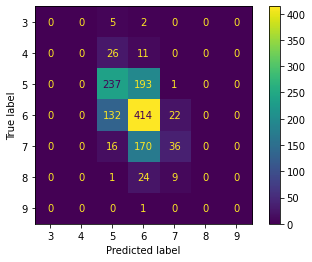

In [15]:
def RegressioLogistica(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    logreg = LogisticRegression(max_iter=5000)
    logreg.fit(X_train,y_train)

    y_predict = logreg.predict(X_test)
    

    print("\nRegressio Logística:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = logreg.score(X_train,y_train)
    testing_accuracy = logreg.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Regressió Logística']=training_accuracy*100
    dfTestAccuracy.at[nom,'Regressió Logística']=testing_accuracy*100 
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logreg.classes_), display_labels=logreg.classes_).plot()
    
    plt.show()

RegressioLogistica(df, "Original")

## Perceptró


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.20      0.08      0.12        37
           5       0.60      0.38      0.46       431
           6       0.48      0.22      0.30       568
           7       0.24      0.82      0.37       222
           8       0.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.36      1300
   macro avg       0.50      0.21      0.18      1300
weighted avg       0.46      0.36      0.35      1300

training accuracy: 36.46334423705984
testing accuracy: 36.30769230769231

Confusion Matrix


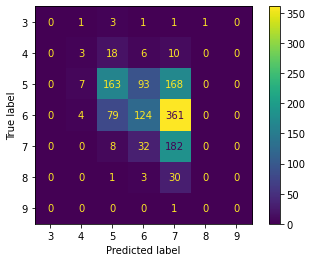

In [16]:
def Perceptro(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    perceptro = Perceptron()
    perceptro.fit(X_train,y_train)

    y_predict = perceptro.predict(X_test)
    
    print("\nPerceptró:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = perceptro.score(X_train,y_train)
    testing_accuracy = perceptro.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Perceptró']=training_accuracy*100
    dfTestAccuracy.at[nom,'Perceptró']=testing_accuracy*100 
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=perceptro.classes_), display_labels=perceptro.classes_).plot()
    
    plt.show()

Perceptro(df, "Original")

## Random Forest

Hem decidit donar-li valor al hiperparàmetre max_depth perquè amb el valor per defecte teniem overfitting.


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.75      0.16      0.27        37
           5       0.71      0.66      0.68       431
           6       0.61      0.77      0.68       568
           7       0.66      0.50      0.57       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.66      0.33      0.36      1300
weighted avg       0.66      0.65      0.64      1300

training accuracy: 97.57552434096594
testing accuracy: 65.0

Confusion Matrix


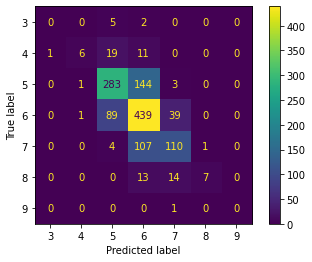

In [17]:
def RandomForest(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(max_depth=14)
    rf.fit(X_train, y_train)

    y_predict=rf.predict(X_test)

    print("\nRandom Forest:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = rf.score(X_train,y_train)
    testing_accuracy = rf.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Random Forest']=training_accuracy*100
    dfTestAccuracy.at[nom,'Random Forest']=testing_accuracy*100
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rf.classes_), display_labels=rf.classes_).plot()  
    plt.show()
           
RandomForest(df, "Original")

## Conclusions


Blablabla

# **Enginyeria de característiques**

L'enginyeria de característiques (feature engineering) és el procés de selecció, extracció, creació i transformació de les característiques d'un dataset amb l'objectiu de millorar l'eficàcia d'un model predictiu.

Per dur a terme l'enginyeria de característiques hem seguit els següents apartats: 
- **Feature importances dels models**: Ens permet saber la importància de cada característica dins cada model amb el fí d'eliminar les característiques menys importants.
- **Correlacions màximes i mínimes**: Ens permet saber quines característiques tenen major correlació entre elles. També ens permet saber quines característiques tenen menys correlació amb la qualitat del vi per després poder eliminar-les.
- **Feature Selection**: Selecció de les característiques més i menys importants. S'implementaran els següents:
   1. Sequential Feature Selection
   2. Univariate Feature Selection amb Kbest
   3. Recursive Feature Elimination

## Feature importances de cada model

In [18]:
dfWquality=df.drop("quality", axis=1)

### Regressió logística <a id='Regressio-Logistica'></a>

Millor característica: volatile acidity
Pitjor característica alcohol


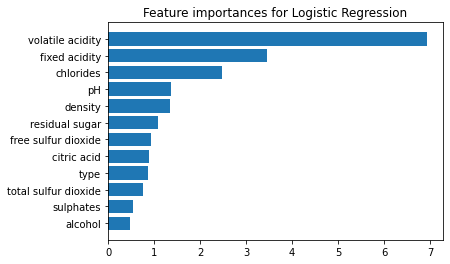

In [19]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

logreg_odds = np.exp(logreg.coef_[0])
indices=np.argsort(logreg_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Logistic Regression")
ax.barh(range(len(logreg_odds)), logreg_odds[indices])
ax.set_yticks(range(len(logreg_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

print("Millor característica:", dfWquality.columns[indices][-1])
pitjorLogReg =dfWquality.columns[indices][0]
print("Pitjor característica", pitjorLogReg)

### Perceptró <a id='Perceptro'></a>

Millor característica: fixed acidity
Pitjor característica: sulphates


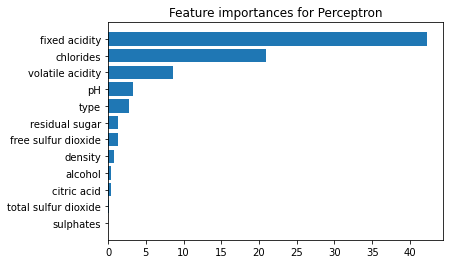

In [20]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

perceptron_odds = np.exp(perceptron.coef_[0])
indices=np.argsort(perceptron_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Perceptron")
ax.barh(range(len(perceptron_odds)), perceptron_odds[indices])
ax.set_yticks(range(len(perceptron_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

print("Millor característica:", dfWquality.columns[indices][-1])
pitjorPerc =dfWquality.columns[indices][0]
print("Pitjor característica:", pitjorPerc)

### Random Forest <a id='Random-Forest'></a>

Millor característica: alcohol
Pitjor característica: type


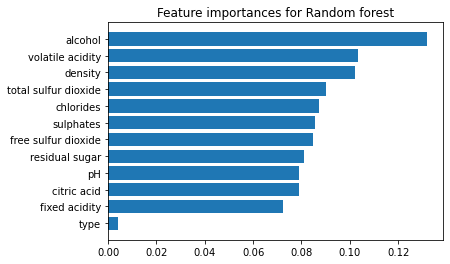

In [21]:
rf = RandomForestClassifier(max_depth=14)
rf.fit(X_train, y_train)

importancesRF = rf.feature_importances_
indices = np.argsort(importancesRF)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Random forest")
ax.barh(range(len(importancesRF)), importancesRF[indices])
ax.set_yticks(range(len(importancesRF)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

print("Millor característica:", dfWquality.columns[indices][-1])
pitjorRF =dfWquality.columns[indices][0]
print("Pitjor característica:", pitjorRF)

### Comparativa entre models
| Model | Millor característica | Pitjor característica |
| ----------- | ----------- | ----------- |
| Regressió Logística | Alcohol | Volatile Acidity |
| Perceptró | Residual Sugar | Density |
| Random Forest | Alcohol | Type |

Es pot observar com l'alcohol dels vins pareix tenir una influència considerable en la qualitat d'aquests ja que, tant a la regressió logística com al random forest, és la millor característica i al perceptró es troba en segon lloc.

Els resultats poden variar depenent de l'execució, aquests valors són els obtinguts a una execució determinada.

## Correlacions màximes i mínimes <a id='Correlacions-Minimes'></a>

In [22]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

print(so[13:23]) #Les 12 primeres son autocorrelacions
print("-------------")
print(so['quality'][10:13])
pitjorsCorrelacions=so['quality'][10:13].to_dict().keys()

corrs = df.corr().abs()['quality']
sig_cols = [col for col in corrs.keys() if col != 'quality' and abs(corrs[col]) > 0.1]
print(sig_cols)

free sulfur dioxide   total sulfur dioxide    0.720934
total sulfur dioxide  free sulfur dioxide     0.720934
type                  total sulfur dioxide    0.700357
total sulfur dioxide  type                    0.700357
density               alcohol                 0.686745
alcohol               density                 0.686745
volatile acidity      type                    0.653036
type                  volatile acidity        0.653036
residual sugar        density                 0.552517
density               residual sugar          0.552517
dtype: float64
-------------
sulphates         0.038485
residual sugar    0.036980
pH                0.019506
dtype: float64
['volatile acidity', 'chlorides', 'density', 'alcohol', 'type']


Les característiques que tenen la major correlació amb la qualitat són el *Free sulfur dioxide* i el *Total sulfur dioxide*. \
Les característiques que tenen la menor correlació amb la qualitat són el *pH*, *residual sugars* i *sulphates*.

## [Feature Selection](https://www.scikit-learn.org/stable/modules/feature_selection.html)

### [Sequential Feature Selector](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) <a id='Sequential-Feature-Selector'></a>


In [23]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [24]:
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="forward"
).fit(X_train, y_train)


sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="backward"
).fit(X_train, y_train)

pitjorSFSF=dfWquality.columns.difference(feature_names[sfs_forward.get_support()]).tolist()
pitjorSFSB=dfWquality.columns.difference(feature_names[sfs_backward.get_support()]).tolist()
print(type(pitjorSFSB))
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{pitjorSFSF}\n"
)

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{pitjorSFSB}"
)

<class 'list'>
Features selected by forward sequential selection: ['volatile acidity' 'residual sugar' 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: ['citric acid', 'fixed acidity']

Features selected by backward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: ['chlorides', 'citric acid']


### [Univariate Feature selection with Kbest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect) <a id='Univariate-feature-selection'></a> 


In [25]:
mask = SelectKBest(f_regression, k=10).fit(X_train, y_train).get_support()

best_features = dfWquality.columns[mask].tolist()
pitjorsUFS = dfWquality.columns.difference(best_features).tolist()

print("Millors característiques: ", best_features)
print("Pitjors característiques: ", pitjorsUFS)

Millors característiques:  ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'sulphates', 'alcohol', 'type']
Pitjors característiques:  ['pH', 'total sulfur dioxide']


### [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <a id='Recursive-feature-elimination'></a> 


In [26]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [27]:
rfe_selector = RFE(ridge, n_features_to_select=10).fit(X_train, y_train)

pitjorsRFE=dfWquality.columns.difference(feature_names[rfe_selector.get_support()]).tolist()
print(
    "Característiques triades pel recursive feature elimination: "
    f"{feature_names[rfe_selector.get_support()]}"
    "\nCaracterístiques no triades pel recursive feature elimination: "
    f"{pitjorsRFE}\n"
)

Característiques triades pel recursive feature elimination: ['fixed acidity' 'volatile acidity' 'residual sugar' 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol']
Característiques no triades pel recursive feature elimination: ['citric acid', 'type']



### 
| Tipus | 1ra Pitjor Caract. | 2na Pitjor Caract.|
| ----------- | ----------- | ----------- |
| Sequential Feature Selection - Forward| Free sulfur dioxide | Total sulfur dioxide |
| Sequential Feature Selection - backward| Chloride | Citric Acid |
| Univariate Feature Selection | pH | Sulphates |
| Recursive Feature Elimination | Citric Acid | Type |

## Proves <a id='Proves'></a>

### Eliminam característiques

In [28]:
dfComentaris = pd.DataFrame(columns=['Comentaris'])

#### Característica de menor importància de la Regressió Logística

Com s'ha observat [aquí](#Regressio-Logistica), el Feature Selection de la Regressió Logística indica que és la característica amb menys importància.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.54      0.46      0.50       431
           6       0.48      0.78      0.59       568
           7       0.20      0.00      0.01       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.49      1300
   macro avg       0.75      0.18      0.16      1300
weighted avg       0.48      0.49      0.42      1300

training accuracy: 51.472003078699245
testing accuracy: 49.38461538461538

Confusion Matrix


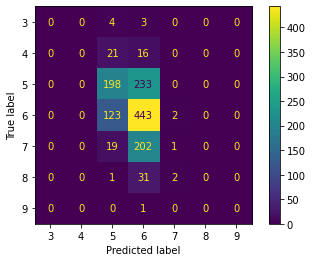


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.48      0.84      0.61       431
           6       0.50      0.43      0.46       568
           7       0.67      0.01      0.02       222
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00         1

    accuracy                           0.47      1300
   macro avg       0.38      0.18      0.16      1300
weighted avg       0.49      0.47      0.41      1300

training accuracy: 47.3927265730229
testing accuracy: 46.92307692307692

Confusion Matrix


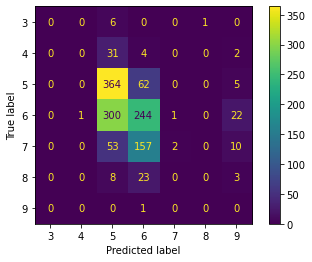


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.62      0.14      0.22        37
           5       0.70      0.65      0.67       431
           6       0.61      0.78      0.69       568
           7       0.70      0.50      0.58       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.79      0.32      0.36      1300
weighted avg       0.67      0.65      0.64      1300

training accuracy: 97.67173369251492
testing accuracy: 65.23076923076923

Confusion Matrix


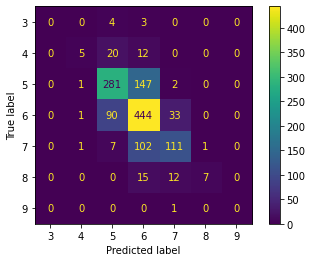

In [29]:
df_menor_LogReg = df.drop(pitjorLogReg,axis=1)

RegressioLogistica(df_menor_LogReg, "menor imp. LogReg")
Perceptro(df_menor_LogReg, "menor imp. LogReg")
RandomForest(df_menor_LogReg, "menor imp. LogReg")

dfComentaris.at["menor imp. LogReg",'Comentaris']=pitjorLogReg

#### Característica de menor importància del Perceptró

Com s'ha observat [aquí](#Perceptro), el Feature Selection del Perceptró indica que és la característica amb menys importància.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.56      0.56      0.56       431
           6       0.50      0.72      0.59       568
           7       0.54      0.14      0.23       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.52      1300
   macro avg       0.80      0.20      0.20      1300
weighted avg       0.56      0.52      0.48      1300

training accuracy: 54.03117182990187
testing accuracy: 52.38461538461539

Confusion Matrix


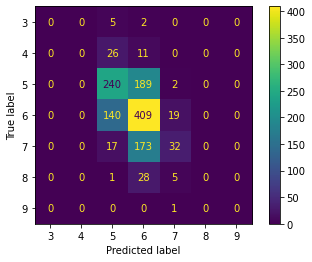


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.67      0.05      0.10        37
           5       0.60      0.26      0.36       431
           6       0.45      0.47      0.46       568
           7       0.30      0.69      0.42       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.41      1300
   macro avg       0.72      0.21      0.19      1300
weighted avg       0.50      0.41      0.39      1300

training accuracy: 42.12045410813931
testing accuracy: 41.0

Confusion Matrix


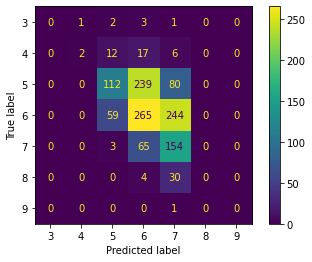


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.86      0.16      0.27        37
           5       0.69      0.64      0.66       431
           6       0.61      0.77      0.68       568
           7       0.66      0.51      0.58       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.64      1300
   macro avg       0.81      0.33      0.36      1300
weighted avg       0.66      0.64      0.63      1300

training accuracy: 97.34462189724842
testing accuracy: 64.38461538461539

Confusion Matrix


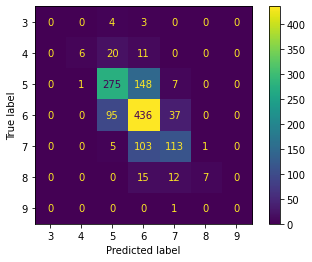

In [30]:
df_menor_Perc = df.drop(pitjorPerc,axis=1)

RegressioLogistica(df_menor_Perc, "menor imp. Perc")
Perceptro(df_menor_Perc, "menor imp. Perc")
RandomForest(df_menor_Perc, "menor imp. Perc")

dfComentaris.at["menor imp. Perc",'Comentaris']=pitjorPerc

#### Característica de menor importància del Random Forest

Com s'ha observat [aquí](#Random-Forest), el Feature Selection del Random Forest indica que és la característica amb menys importància.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.74      0.61       568
           7       0.59      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.81      0.21      0.20      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.51221858764672
testing accuracy: 53.46153846153846

Confusion Matrix


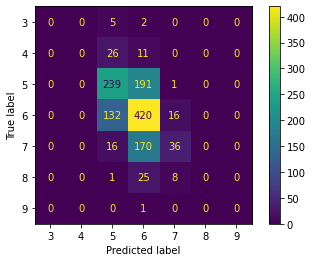


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.58      0.52      0.55       431
           6       0.49      0.76      0.60       568
           7       0.33      0.06      0.10       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.51      1300
   macro avg       0.63      0.19      0.18      1300
weighted avg       0.52      0.51      0.46      1300

training accuracy: 51.89532422551471
testing accuracy: 51.23076923076923

Confusion Matrix


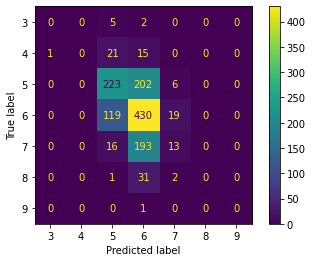


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       1.00      0.22      0.36        37
           5       0.70      0.66      0.68       431
           6       0.61      0.77      0.68       568
           7       0.67      0.50      0.57       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.69      0.34      0.37      1300
weighted avg       0.67      0.65      0.64      1300

training accuracy: 97.7487011737541
testing accuracy: 65.07692307692308

Confusion Matrix


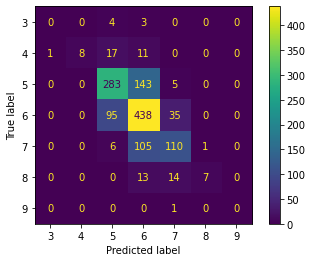

In [31]:
df_menor_RF = df.drop(pitjorRF,axis=1)

RegressioLogistica(df_menor_RF, "menor imp. RF")
Perceptro(df_menor_RF, "menor imp. RF")
RandomForest(df_menor_RF, "menor imp. RF")

dfComentaris.at["menor imp. RF",'Comentaris']=pitjorRF

#### Característica amb les pitjors correlacions amb la qualitat

Com s'ha observat [aquí](#Correlacions-Minimes), són les tres característiques menys correlacionades amb la qualitat.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.56      0.56      0.56       431
           6       0.50      0.71      0.58       568
           7       0.51      0.13      0.21       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.52      1300
   macro avg       0.79      0.20      0.19      1300
weighted avg       0.55      0.52      0.48      1300

training accuracy: 53.35770636905907
testing accuracy: 51.69230769230769

Confusion Matrix


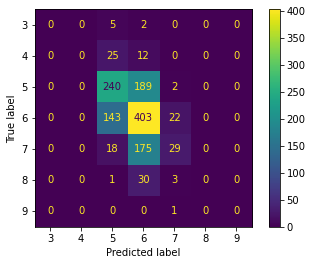


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.36      0.14      0.20        37
           5       0.69      0.13      0.23       431
           6       0.43      0.38      0.41       568
           7       0.24      0.75      0.36       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.34      1300
   macro avg       0.67      0.20      0.17      1300
weighted avg       0.50      0.34      0.32      1300

training accuracy: 32.114681547046374
testing accuracy: 34.38461538461539

Confusion Matrix


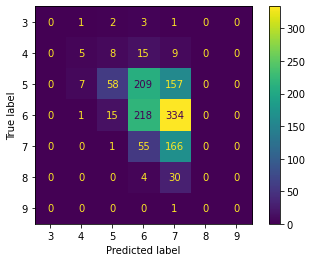


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.86      0.16      0.27        37
           5       0.70      0.63      0.66       431
           6       0.60      0.77      0.67       568
           7       0.63      0.48      0.54       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.64      1300
   macro avg       0.67      0.32      0.36      1300
weighted avg       0.65      0.64      0.62      1300

training accuracy: 96.70964017702521
testing accuracy: 63.61538461538462

Confusion Matrix


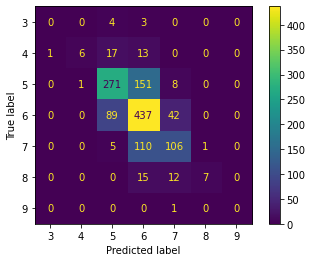

In [32]:
df_Correlacions = df.drop(pitjorsCorrelacions,axis=1)

RegressioLogistica(df_Correlacions, "Pitjors carac. Correlacions")
Perceptro(df_Correlacions, "Pitjors carac. Correlacions")
RandomForest(df_Correlacions, "Pitjors carac. Correlacions")

dfComentaris.at["Pitjors carac. Correlacions",'Comentaris']=pitjorsCorrelacions

#### Característica amb les pitjors característiques del Forward Feature Selection

Com s'ha observat [aquí](#Sequential-Feature-Selector), ja que el Forward Feature Selection indica que són les dues pitjors característiques.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.74      0.60       568
           7       0.57      0.15      0.24       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.81      0.21      0.20      1300
weighted avg       0.57      0.53      0.49      1300

training accuracy: 54.800846642293635
testing accuracy: 53.230769230769226

Confusion Matrix


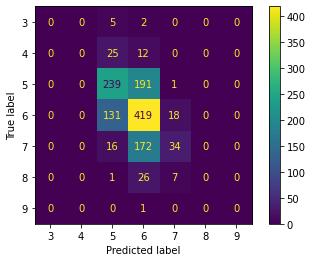


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.54      0.67      0.60       431
           6       0.49      0.49      0.49       568
           7       0.40      0.37      0.39       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.50      1300
   macro avg       0.78      0.22      0.21      1300
weighted avg       0.52      0.50      0.48      1300

training accuracy: 52.24167789109101
testing accuracy: 49.92307692307693

Confusion Matrix


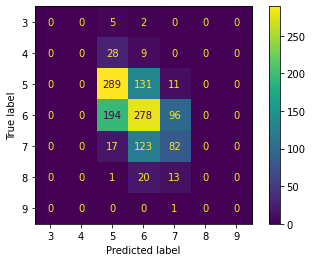


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.19      0.32        37
           5       0.70      0.65      0.67       431
           6       0.62      0.77      0.68       568
           7       0.65      0.54      0.59       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.84      0.33      0.37      1300
weighted avg       0.67      0.65      0.64      1300

training accuracy: 96.74812391764479
testing accuracy: 65.15384615384615

Confusion Matrix


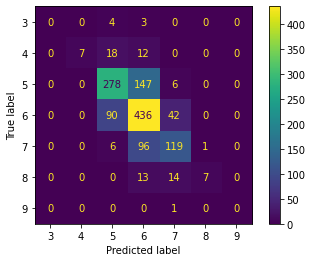

In [33]:
df_SFSF = df.drop(pitjorSFSF,axis=1)

RegressioLogistica(df_SFSF, "Pitjors carac. SFSF")
Perceptro(df_SFSF, "Pitjors carac. SFSF")
RandomForest(df_SFSF, "Pitjors carac. SFSF")

dfComentaris.at["Pitjors carac. SFSF",'Comentaris']=pitjorSFSF

#### Pitjors característiques Backward Feature Selection

Com s'ha observat [aquí](#Sequential-Feature-Selector), el Backward Feature Selection indica que són les dues pitjors característiques.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.56      0.55      0.55       431
           6       0.51      0.73      0.60       568
           7       0.54      0.17      0.26       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.49297671733693
testing accuracy: 52.76923076923077

Confusion Matrix


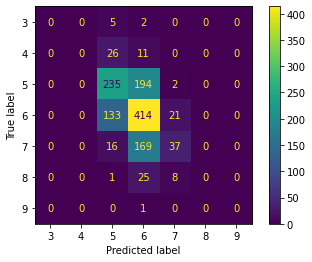


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.54      0.72      0.62       431
           6       0.52      0.27      0.36       568
           7       0.34      0.66      0.45       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.47      1300
   macro avg       0.77      0.24      0.20      1300
weighted avg       0.53      0.47      0.44      1300

training accuracy: 45.410813931114106
testing accuracy: 47.0

Confusion Matrix


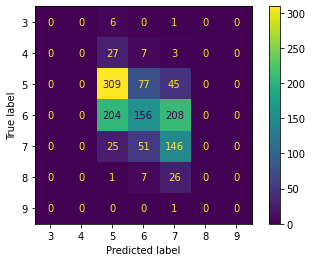


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.71      0.14      0.23        37
           5       0.71      0.67      0.69       431
           6       0.62      0.78      0.69       568
           7       0.70      0.50      0.58       222
           8       0.75      0.18      0.29        34
           9       1.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.64      0.32      0.35      1300
weighted avg       0.67      0.66      0.65      1300

training accuracy: 97.11371945353088
testing accuracy: 65.92307692307692

Confusion Matrix


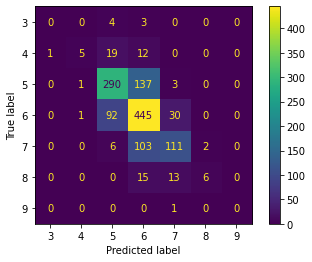

In [34]:
df_SFSB = df.drop(pitjorSFSB,axis=1)

RegressioLogistica(df_SFSB, "Pitjors carac. SFSB")
Perceptro(df_SFSB, "Pitjors carac. SFSB")
RandomForest(df_SFSB, "Pitjors carac. SFSB")

dfComentaris.at["Pitjors carac. SFSB",'Comentaris']=pitjorSFSB

#### Pitjors característiques Univariate Feature Selection

Com s'ha observat [aquí](#Univariate-feature-selection), el SelectKBest indica que són les dues pitjors característiques.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.56      0.55      0.55       431
           6       0.50      0.72      0.59       568
           7       0.57      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.52      1300
   macro avg       0.80      0.20      0.20      1300
weighted avg       0.56      0.52      0.48      1300

training accuracy: 53.76178564556475
testing accuracy: 52.23076923076923

Confusion Matrix


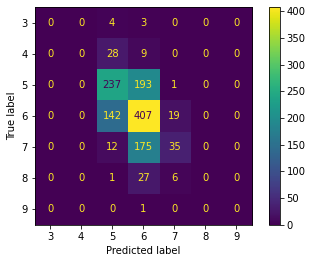


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.58      0.52      0.55       431
           6       0.48      0.74      0.58       568
           7       0.43      0.07      0.12       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.51      1300
   macro avg       0.64      0.19      0.18      1300
weighted avg       0.51      0.51      0.45      1300

training accuracy: 52.722724648835865
testing accuracy: 50.61538461538462

Confusion Matrix


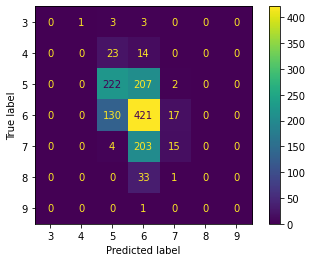


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.80      0.11      0.19        37
           5       0.68      0.64      0.66       431
           6       0.60      0.76      0.67       568
           7       0.68      0.49      0.57       222
           8       0.89      0.24      0.37        34
           9       1.00      0.00      0.00         1

    accuracy                           0.64      1300
   macro avg       0.66      0.32      0.35      1300
weighted avg       0.65      0.64      0.62      1300

training accuracy: 97.15220319415046
testing accuracy: 63.61538461538462

Confusion Matrix


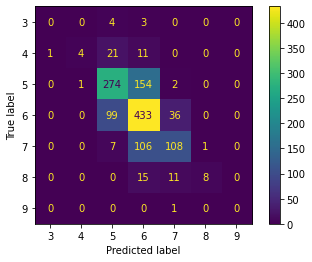

In [35]:
df_UFS = df.drop(pitjorsUFS,axis=1)

RegressioLogistica(df_UFS, "Pitjors carac. UFS")
Perceptro(df_UFS, "Pitjors carac. UFS")
RandomForest(df_UFS, "Pitjors carac. UFS")

dfComentaris.at["Pitjors carac. UFS",'Comentaris']=pitjorsUFS

#### Pitjors característiques Recursive Feature Selection

Com hem vist [aquí](#Recursive-feature-elimination), el Recursive Feature Elimination indica que són les dues pitjors característiques.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.74      0.60       568
           7       0.61      0.18      0.27       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.81      0.21      0.21      1300
weighted avg       0.58      0.53      0.50      1300

training accuracy: 54.30055801423899
testing accuracy: 53.46153846153846

Confusion Matrix


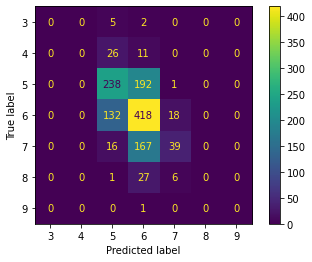


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.53      0.70      0.60       431
           6       0.50      0.41      0.45       568
           7       0.40      0.47      0.43       222
           8       0.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.49      1300
   macro avg       0.63      0.23      0.21      1300
weighted avg       0.50      0.49      0.47      1300

training accuracy: 50.413700211660576
testing accuracy: 49.07692307692308

Confusion Matrix


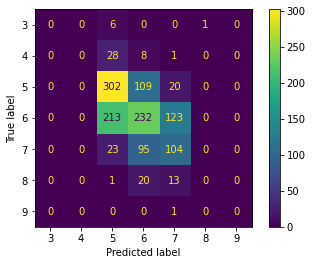


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       1.00      0.16      0.28        37
           5       0.70      0.66      0.68       431
           6       0.62      0.77      0.69       568
           7       0.66      0.51      0.58       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.69      0.33      0.37      1300
weighted avg       0.67      0.65      0.64      1300

training accuracy: 96.99826823167211
testing accuracy: 65.38461538461539

Confusion Matrix


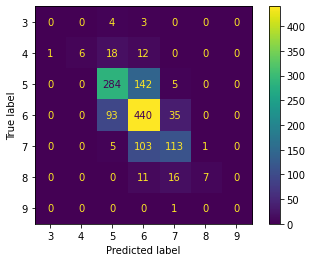

In [36]:
df_RFE = df.drop(pitjorsRFE,axis=1)

RegressioLogistica(df_RFE, "Pitjors carac. RFE")
Perceptro(df_RFE, "Pitjors carac. RFE")
RandomForest(df_RFE, "Pitjors carac. RFE")

dfComentaris.at["Pitjors carac. RFE",'Comentaris']=pitjorsRFE

### Cream característiques

#### Àcids totals


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.53      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.45449297671734
testing accuracy: 52.84615384615384

Confusion Matrix


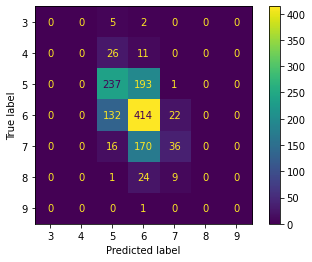


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.62      0.05      0.10       431
           6       0.45      0.99      0.62       568
           7       1.00      0.00      0.00       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.45      1300
   macro avg       0.87      0.15      0.10      1300
weighted avg       0.63      0.45      0.30      1300

training accuracy: 45.17991148739657
testing accuracy: 45.15384615384615

Confusion Matrix


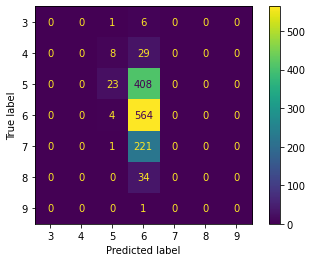


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.83      0.14      0.23        37
           5       0.71      0.65      0.68       431
           6       0.61      0.79      0.69       568
           7       0.68      0.50      0.57       222
           8       0.80      0.24      0.36        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.81      0.33      0.36      1300
weighted avg       0.67      0.65      0.64      1300

training accuracy: 97.69097556282472
testing accuracy: 65.46153846153845

Confusion Matrix


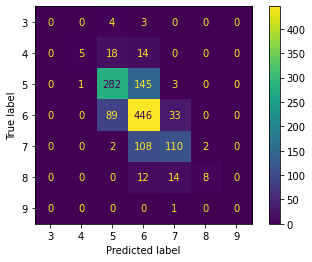

In [37]:
combinator_Acid_Tot = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['sum'],
    new_variables_names = ['total_acidity']
)

df_Acid_Tot = combinator_Acid_Tot.fit_transform(df)

RegressioLogistica(df_Acid_Tot, "Acid Totals")
Perceptro(df_Acid_Tot, "Acid Totals")
RandomForest(df_Acid_Tot, "Acid Totals")

#### Percentatge d'àcid cítric respecte de l'acidesa fixada


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.53      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.37752549547816
testing accuracy: 52.92307692307693

Confusion Matrix


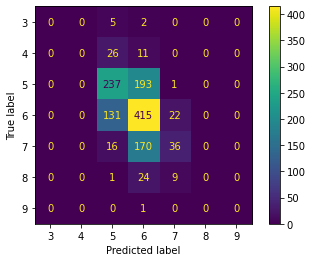


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.45      0.93      0.60       431
           6       0.51      0.08      0.14       568
           7       0.39      0.55      0.46       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.44      1300
   macro avg       0.76      0.22      0.17      1300
weighted avg       0.50      0.44      0.34      1300

training accuracy: 42.50529151433519
testing accuracy: 43.69230769230769

Confusion Matrix


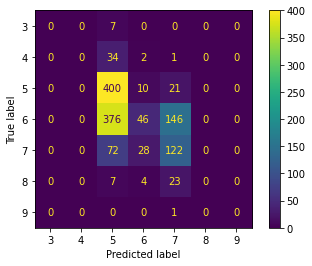


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.83      0.14      0.23        37
           5       0.71      0.66      0.68       431
           6       0.62      0.79      0.70       568
           7       0.69      0.50      0.58       222
           8       0.89      0.24      0.37        34
           9       1.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.82      0.33      0.37      1300
weighted avg       0.68      0.66      0.65      1300

training accuracy: 97.46007311910718
testing accuracy: 66.0

Confusion Matrix


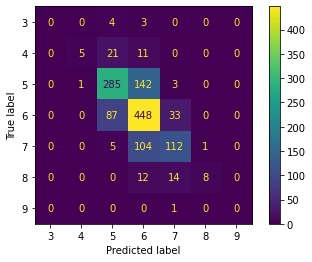

In [38]:
combinator_PercAC = CombineWithReferenceFeature(
    variables_to_combine=['citric acid'],
    reference_variables=['fixed acidity'],
    operations=['div'],   
    new_variables_names=['percentage_citric_acid'])

df_PercAC = combinator_PercAC.fit_transform(df)

RegressioLogistica(df_PercAC, "Perc. acid citric")
Perceptro(df_PercAC, "Perc. acid citric")
RandomForest(df_PercAC, "Perc. acid citric")

#### Minerals totals


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.53      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.31979988454878
testing accuracy: 52.69230769230769

Confusion Matrix


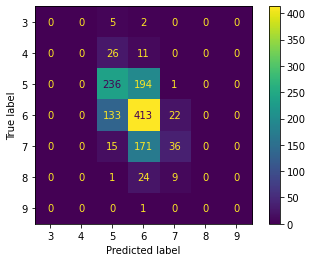


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.56      0.51      0.53       431
           6       0.48      0.30      0.37       568
           7       0.29      0.71      0.41       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.42      1300
   macro avg       0.48      0.22      0.19      1300
weighted avg       0.47      0.42      0.41      1300

training accuracy: 43.486626900134695
testing accuracy: 42.30769230769231

Confusion Matrix


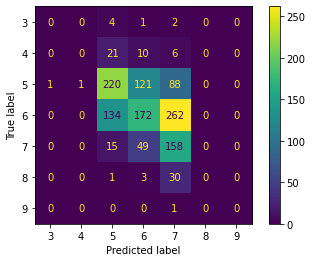


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.89      0.22      0.35        37
           5       0.71      0.65      0.68       431
           6       0.61      0.79      0.69       568
           7       0.69      0.50      0.58       222
           8       1.00      0.24      0.38        34
           9       1.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.70      0.34      0.38      1300
weighted avg       0.67      0.66      0.64      1300

training accuracy: 97.53704060034636
testing accuracy: 65.61538461538461

Confusion Matrix


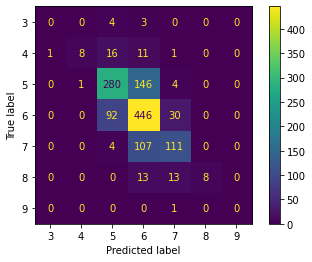

In [39]:
combinator_Minerals_Totals = MathematicalCombination(
    variables_to_combine=['chlorides', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

df_Minerals_Totals = combinator_Minerals_Totals.fit_transform(df)

RegressioLogistica(df_Minerals_Totals, "Minerals totals")
Perceptro(df_Minerals_Totals, "Minerals totals")
RandomForest(df_Minerals_Totals, "Minerals totals")

#### Percentatge de diòxid de sofre lliure


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.58      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.51      0.17      0.26       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 55.01250721570137
testing accuracy: 53.07692307692308

Confusion Matrix


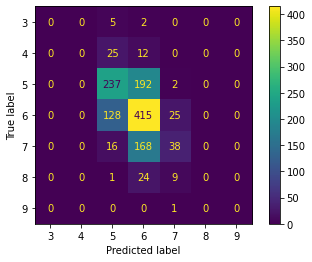


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.17      0.16      0.17        37
           5       0.60      0.45      0.52       431
           6       0.49      0.81      0.61       568
           7       0.40      0.01      0.02       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.51      1300
   macro avg       0.67      0.20      0.19      1300
weighted avg       0.52      0.51      0.45      1300

training accuracy: 51.491244949009044
testing accuracy: 51.0

Confusion Matrix


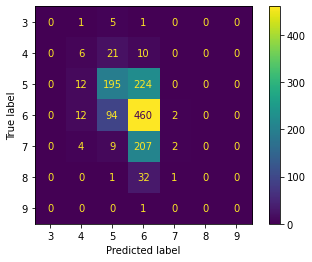


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.86      0.16      0.27        37
           5       0.69      0.65      0.67       431
           6       0.61      0.77      0.68       568
           7       0.69      0.50      0.58       222
           8       0.78      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.66      0.33      0.36      1300
weighted avg       0.66      0.65      0.63      1300

training accuracy: 97.55628247065616
testing accuracy: 64.6923076923077

Confusion Matrix


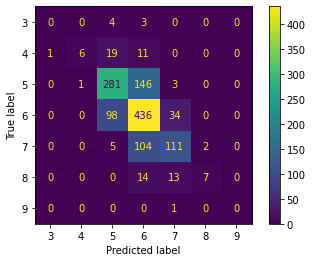

In [40]:
combinator_PercSO2 = CombineWithReferenceFeature(
    variables_to_combine=['free sulfur dioxide'],
    reference_variables=['total sulfur dioxide'],
    operations=['div'],   
    new_variables_names=['percentage_free_sulfur'])

df_PercSO2 = combinator_PercSO2.fit_transform(df)

RegressioLogistica(df_PercSO2, "Perc. SO2 lliure")
Perceptro(df_PercSO2, "Perc. SO2 lliure")
RandomForest(df_PercSO2, "Perc. SO2 lliure")

#### Diòxid de sofre no lliure


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.54      0.17      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.31979988454878
testing accuracy: 53.0

Confusion Matrix


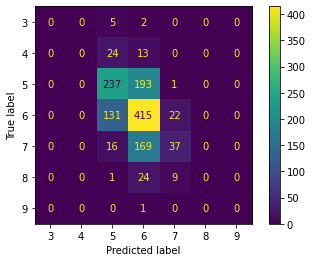


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.48      0.87      0.62       431
           6       0.54      0.22      0.32       568
           7       0.43      0.54      0.48       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.48      1300
   macro avg       0.78      0.23      0.20      1300
weighted avg       0.53      0.48      0.42      1300

training accuracy: 46.623051760631135
testing accuracy: 47.84615384615385

Confusion Matrix


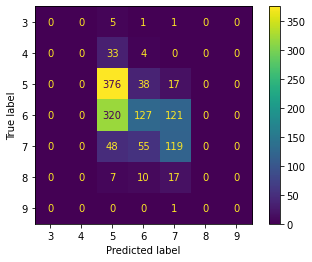


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.88      0.19      0.31        37
           5       0.70      0.65      0.68       431
           6       0.61      0.78      0.69       568
           7       0.66      0.50      0.57       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.68      0.33      0.37      1300
weighted avg       0.66      0.65      0.64      1300

training accuracy: 97.65249182220512
testing accuracy: 65.0

Confusion Matrix


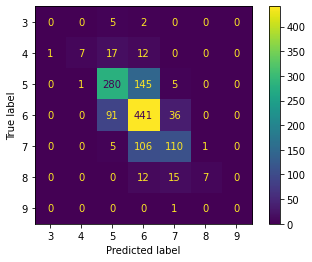

In [41]:
combinator_No_FreeSO2 = CombineWithReferenceFeature(
    variables_to_combine=['total sulfur dioxide'],
    reference_variables=['free sulfur dioxide'],
    operations=['sub'],
    new_variables_names=['non_free_sulfur_dioxide']
)

df_No_FreeSO2 = combinator_No_FreeSO2.fit_transform(df)

RegressioLogistica(df_No_FreeSO2, "S02 no lliure")
Perceptro(df_No_FreeSO2, "S02 no lliure")
RandomForest(df_No_FreeSO2, "S02 no lliure")


#### Dels diòxid de sofre quin percentatge és una sal


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.57      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.53      0.16      0.25       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 54.51221858764672
testing accuracy: 52.84615384615384

Confusion Matrix


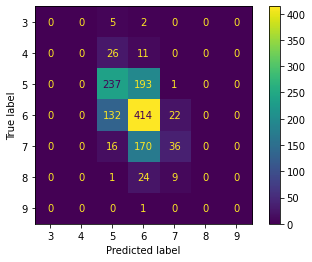


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.00      0.00      0.00        37
           5       0.52      0.77      0.62       431
           6       0.56      0.21      0.31       568
           7       0.33      0.65      0.43       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.46      1300
   macro avg       0.63      0.23      0.19      1300
weighted avg       0.50      0.46      0.41      1300

training accuracy: 44.063883009428515
testing accuracy: 46.0

Confusion Matrix


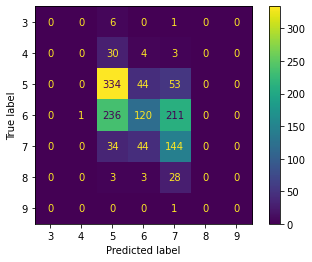


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.71      0.14      0.23        37
           5       0.72      0.66      0.69       431
           6       0.62      0.78      0.69       568
           7       0.64      0.50      0.56       222
           8       0.80      0.24      0.36        34
           9       1.00      0.00      0.00         1

    accuracy                           0.65      1300
   macro avg       0.64      0.33      0.36      1300
weighted avg       0.66      0.65      0.64      1300

training accuracy: 97.69097556282472
testing accuracy: 65.3076923076923

Confusion Matrix


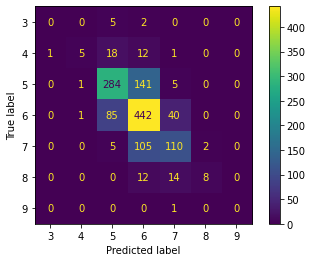

In [42]:
combinator_Sulfurs_Sals = CombineWithReferenceFeature(
    variables_to_combine=['sulphates'],
    reference_variables=['free sulfur dioxide'],
    operations=['div'],
    new_variables_names=['percentage_salt_sulfur']
)

df_Sulfurs_Sals = combinator_Sulfurs_Sals.fit_transform(df)

RegressioLogistica(df_Sulfurs_Sals, "Sulfurs Sals")
Perceptro(df_Sulfurs_Sals, "Sulfurs Sals")
RandomForest(df_Sulfurs_Sals, "Sulfurs Sals")


#### Prova


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       1.00      0.00      0.00        37
           5       0.58      0.55      0.56       431
           6       0.51      0.73      0.60       568
           7       0.50      0.17      0.26       222
           8       1.00      0.00      0.00        34
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.56      0.53      0.49      1300

training accuracy: 55.05099095632096
testing accuracy: 53.0

Confusion Matrix


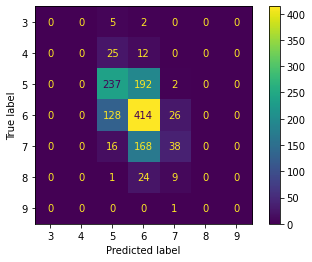


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         7
           4       0.07      0.03      0.04        37
           5       0.39      0.96      0.55       431
           6       0.47      0.05      0.09       568
           7       0.43      0.28      0.34       222
           8       0.44      0.12      0.19        34
           9       1.00      0.00      0.00         1

    accuracy                           0.39      1300
   macro avg       0.54      0.21      0.17      1300
weighted avg       0.43      0.39      0.29      1300

training accuracy: 38.63767558206658
testing accuracy: 39.23076923076923

Confusion Matrix


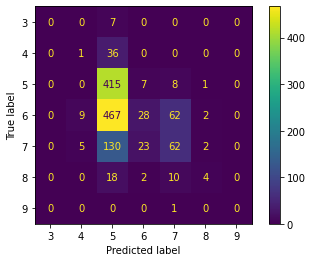


Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.78      0.19      0.30        37
           5       0.71      0.65      0.68       431
           6       0.62      0.79      0.69       568
           7       0.69      0.49      0.57       222
           8       0.88      0.21      0.33        34
           9       1.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.67      0.33      0.37      1300
weighted avg       0.67      0.66      0.64      1300

training accuracy: 97.65249182220512
testing accuracy: 65.53846153846153

Confusion Matrix


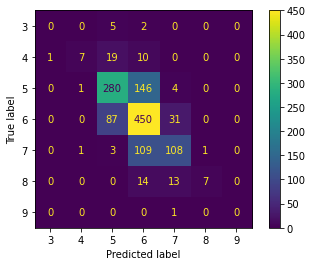

In [43]:
df_Prova = combinator_Acid_Tot.fit_transform(df)
df_Prova = combinator_PercSO2.fit_transform(df_Prova)

RegressioLogistica(df_Prova, "Prova")
Perceptro(df_Prova, "Prova")
RandomForest(df_Prova, "Prova")

#### Unim totes les creacions

In [44]:
df_Unió = combinator_Acid_Tot.fit_transform(df)
df_Unió = combinator_Minerals_Totals.fit_transform(df_Unió)
df_Unió = combinator_PercAC.fit_transform(df_Unió)
df_Unió = combinator_No_FreeSO2.fit_transform(df_Unió)
df_Unió = combinator_PercSO2.fit_transform(df_Unió)
df_Unió = combinator_Sulfurs_Sals.fit_transform(df_Unió)

RegressioLogisitca(df_Unió, "Totes creacions")
Perceptro(df_Unió, "Totes creacions")
RandomForest(df_Unió, "Totes creacions")

NameError: name 'RegressioLogisitca' is not defined

### Comparam les precisions

In [ ]:
print("Training accuracy for each model and each dataframe\n", dfTrainAccuracy)
print("\nTesting accuracy for each model and each dataframe\n", dfTestAccuracy)
print("\n\nLes features eliminades han sigut", dfComentaris)

In [ ]:
dfDiffs = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
for index, row in dfTestAccuracy.iterrows():
    dfDiffs.at[row.name]=row-dfTestAccuracy.loc['Original']
dfDiffs['Media'] = dfDiffs.mean(axis=1)
print(dfDiffs)

# **Grid Search CV**

In [ ]:
features, labels = load_data(df)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### Regressió Logística

In [ ]:
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10,100,1000,2500,5000,7500,10000],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}
# Create a based model
logreg = LogisticRegression()
# Instantiate the grid search model
grid_search_logreg = GridSearchCV(estimator = logreg, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_logreg.fit(X_train, y_train)

print(grid_search_logreg.best_params_)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_predict=logreg.predict(X_test)

print("\nLogistic Regression:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = logreg.score(X_train,y_train)
testing_accuracy = logreg.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logreg.classes_), display_labels=logreg.classes_).plot()  
plt.show()

#---------------------------------------------------------------------------

logregTunnedParams = logreg.set_params(**grid_search_logreg.best_params_)
logregTunnedParams.fit(X_train, y_train)

y_predict=logregTunnedParams.predict(X_test)

print("\nLogistic Regression:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = logregTunnedParams.score(X_train,y_train)
testing_accuracy = logregTunnedParams.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logregTunnedParams.classes_), display_labels=logregTunnedParams.classes_).plot()  
plt.show()

### Perceptró

In [ ]:
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100,1000,2500,5000,7500,10000],
    'early_stopping': [True, False],
}
# Create a based model
perceptro = Perceptron()
# Instantiate the grid search model
grid_search_Perc = GridSearchCV(estimator = perceptro, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_Perc.fit(X_train, y_train)

print(grid_search_Perc.best_params_)

In [ ]:
perc = Perceptron()
perc.fit(X_train, y_train)

y_predict=perc.predict(X_test)

print("\nPerceptron:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = perc.score(X_train,y_train)
testing_accuracy = perc.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=perc.classes_), display_labels=perc.classes_).plot()  
plt.show()

#---------------------------------------------------------------------------

percTunnedParams = perc.set_params(**grid_search_Perc.best_params_)
percTunnedParams.fit(X_train, y_train)

y_predict=percTunnedParams.predict(X_test)

print("\nPerceptron:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = percTunnedParams.score(X_train,y_train)
testing_accuracy = percTunnedParams.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=percTunnedParams.classes_), display_labels=percTunnedParams.classes_).plot()  
plt.show()

### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier(max_depth=14)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)

print(grid_search_rf.best_params_)


In [ ]:
y_predict=rf.predict(X_test)

print("\nRandom Forest:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = rf.score(X_train,y_train)
testing_accuracy = rf.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rf.classes_), display_labels=rf.classes_).plot()  
plt.show()

#---------------------------------------------------------------------------

rfTunnedParams = rf.set_params(**grid_search_rf.best_params_)
rfTunnedParams.fit(X_train, y_train)

y_predict=rfTunnedParams.predict(X_test)

print("\nRandom Forest:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = rfTunnedParams.score(X_train,y_train)
testing_accuracy = rfTunnedParams.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rfTunnedParams.classes_), display_labels=rfTunnedParams.classes_).plot()  
plt.show()
